In [12]:
from sklearn.datasets import fetch_openml 

import numpy as np 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [13]:
## No longer supports fetch_ml data 
## Use fetch_openml instead, need to sort the results as well 
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

In [14]:
## Reorder array - separate the training and the testing parts of the dataset 
def reorder_mnist(mnist, end_train_index=60000):
    '''
    Will return a train set with labels in order (i.e. 0,0,0,...1,1,1,......9,9,9)
    Same for test set
    @note: 
    - Make sure to select last column to get only index and not label (although sorting by label)
    '''
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:end_train_index])]))[:,1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[end_train_index:])]))[:,1]
    mnist.data[:end_train_index] = mnist.data[reorder_train]
    mnist.target[:end_train_index] = mnist.target[reorder_train]
    mnist.data[end_train_index:] = mnist.data[reorder_test + end_train_index]
    mnist.target[end_train_index:] = mnist.target[reorder_test + end_train_index]

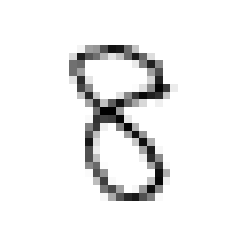

8


In [38]:
## Get the features, response variable 
X, y = mnist['data'], mnist['target']

## Examine one of the instances of the mnist test set 
some_digit = X[3600]
some_digit_label = y[3600]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
          interpolation='nearest')
plt.axis('off')
plt.show()
print(some_digit_label)

In [16]:
## Get train and test set, and reorder the training set to 
## ... make sure folds have a good variety of numnbers (using np.random)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_indices = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]

## Training a Binary Classifier 

In [17]:
## Build a simple binary classifier (5 or not 5)
## using a Stochastic Gradient Descent Classifier 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])


array([False])

In [18]:
## Implementing cross validation 
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf) # clones and yields estimator with same parameters, but without any data attached to it 
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96805
0.9611
0.9645


In [19]:
## Use cross_val_score from sklearn.model_selection to evaluate your model 
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')
scores

array([0.9587, 0.9594, 0.9657])

In [20]:
## Create a Base Estimator that will predict all False 
## Shows flaws of above model - barely performs any better than the Naive model below 
## Be careful when dealing with classification problems on skewed data! 
class NeverSClassifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(Self,X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = NeverSClassifier() 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90715, 0.91315, 0.90865])

In [21]:
## Confusion Matrix 
## Use cross_val_predict to perform k-fold CV, byt instead of returning eval scores
## ...the function returns the predictions made on each test fold 
## Also use confusion_matrix from sklearn.metrics 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred)

array([[52873,  1706],
       [  817,  4604]])

In [22]:
## Precision and recall 
## Can use sklearn.metrics' functions recall and precision to compute classifier metrics 
print("Precision:",round(precision_score(y_train_5, y_train_pred),2))
print("Recall:",round(recall_score(y_train_5, y_train_pred),2))

## Alternatively, use an F-score
## F-score combines precision and recall into a single metric 
## Pros: Easier to compare multiple models 
## It's the harmonic mean of precision and recall 
## Note: Harmonic mean gives smaller weight to values that are low 
## ... For a high harmonic mean, both prec. and recall need to be high 
print("F1 score", round(f1_score(y_train_5, y_train_pred),2))


## @note on precision and recall 
## @source https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9 
## Remember: A classifier with high precision is equivalent to casting a very narrow but specialized 
## ...net. You will only catch a small amount of fish and you will miss out on a lot of fish
## ...A classifier with high recall but low precision is equivalent to casting a very wide net: 
## ...You will catch a lot of fish, but also a lot of things you don't want to catch 

Precision: 0.73
Recall: 0.85
F1 score 0.78


In [23]:
## The Precision and Recall Tradeoff
## Increasing the threshold increases precision, but also reduces recall 
## Reminder: Precision is, out of the selected positive instances, how many are actual positives
## ...Recall is, out of all positive instances, how many were selected? 

## @note:sci-kit does not give you access to threshold. Can return the raw scores and 
## ...set the score manually - using the decision_function() method (instead of using predict())
y_scores = sgd_clf.decision_function([some_digit])
y_scores ## Weird... returns a score but doesn't seem to be bounded - get all scores and normalize? 

array([-4276.28855399])

In [24]:
## Get all scores using cv, but this time use method='de(cision_function' instead of 'accuracy'
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

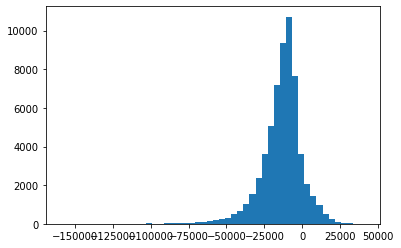

In [25]:
plt.hist(y_scores, bins = 50);

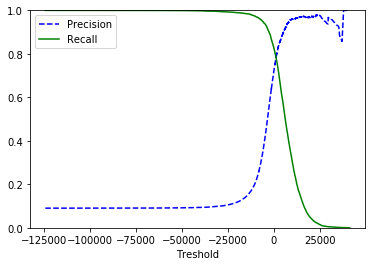

In [26]:
## Fancier plot - from the book 
## Get the precision recall curves pairs for different thresholds using precision_recall_curve() function
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision, recall, threshold, bool_normalize = False):
    if bool_normalize:
        threshold = (threshold - min(threshold)) / (max(threshold) - min(threshold))
    plt.plot(threshold, precision[:-1], 'b--', label = "Precision")
    plt.plot(threshold, recall[:-1], 'g-', label = "Recall")
    plt.xlabel("Treshold")
    plt.legend(loc='upper left')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precision, recall, threshold) ## Weird dip for precision shouldnt happen 

## @note: 
## Precision can have a bumpier curve than recall 
## Say you have the following labels along the score
## 5 - 2 - 5 - 5 - 6 - 5 - 5 - 5 
## If you increase the threshold, recall can only go down 
## But increasing threshold can lead to a decrease in precision 
## e.g. if increase thresh. right before 6 label score

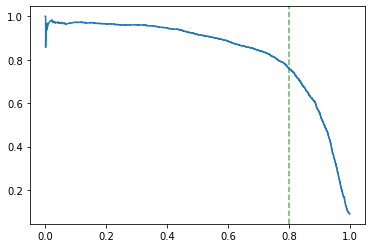

In [27]:
## Another good way to select best thresh. is to plot precision vs. recall 
# plt.plot(precision, recall) # Wrong!
plt.plot(recall, precision)
plt.axvline(x=.8, linestyle='--', color = 'g', alpha = .6)

In [28]:
## Set the scores based on the above scores - say you want a precision ~=90 
y_train_pred_90 = y_scores > 2500
print("Precision",precision_score(y_train_5, y_train_pred_90))
print("Recall:",recall_score(y_train_5, y_train_pred_90))

## @remember: If someone says build a classifier with preciion at 99% - ask: at what recall? 

Precision 0.8300336983993261
Recall: 0.7269876406567054


In [29]:
## Recap of above: 
## Can plot precision / recall against threshold to find a sweet spot. 
## Alternatively, plot precision vs recall and find the approx. point where 
##...precision starts to drop

In [30]:
## The ROC curve 
## Receiver Operating Characteristic curve is another tool to evaluate binary classifiers 
## Instead of plotting precision vs. recall as seen above, we are plotting
## ... True Positive Rate vs. False Positive Rate 
## TPR = Sensitivity = Recall = TP / (TP + FN) (ie. how many of the actual positives did we capture)
## FPR = Specificity = 1-TNR (True Negative Rate) = FP / (FP + TN) = 1 - (TN/(TN+FP)) 
## ... (ie. Ratio of negative instances that are incorrectly classified as positive)

## First compute TPR and FPR (sensitivy, specificity) 
fpr,tpr,threshold = roc_curve(y_train_5, y_scores)

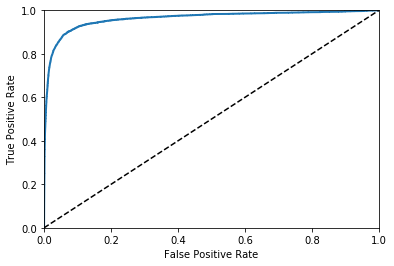

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1]) # set xmin,xmax,ymin,ymax
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [32]:
## To compare classifiers, calc. AUC (Area Under the Curve)
## A good classifier will have an ROC curve that hugs the upper left corner 
## A purely random classifier's perf. is represented by the dotted line 
roc_auc_score(y_train_5, y_scores)

0.9623852157339027

In [33]:
## @note @important: When to use PR curve (Precision/Recall) vs ROC 
## Use a PR curve when either: 
## - The positive class is rate 
## - Care more about false positives than false negatives 
## PR curve makes it clear that there is room for improvement .
## ROC curve can give you false illusion that model is performing well 

In [34]:
## Compare to RAndom Forest model 
forest_clf = RandomForestClassifier(random_state=42)
y_probab = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                          method='predict_proba') 

## @note: in sklearn, rf does not have decision_func method. 
## Instead, use predict_proba. Will return rows of probability for each class (each column is a class)

/Users/elieharik/miniconda3/envs/analytics_all/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elieharik/miniconda3/envs/analytics_all/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elieharik/miniconda3/envs/analytics_all/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


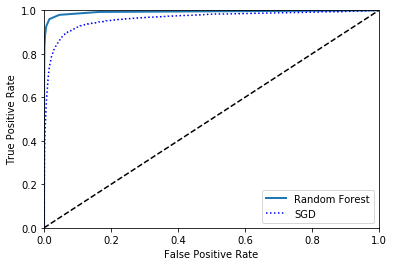

In [35]:
print(y_probab) ## Only 2 classes

## Quick hack: Select the Positive class probability as a score 
y_score_forest = y_probab[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_score_forest)

## Plot ROC curve 
plot_roc_curve(fpr_forest,tpr_forest, 'Random Forest')
plt.plot(fpr,tpr,'b:',label='SGD')
plt.legend(loc='lower right')
plt.show() ## RF Performs better. 

In [37]:
## Multiclass Classification 

## For alogrithms that are not able to do multiclass classification:
## Two strategies: 
## 1. One vs all:
## ... If want to train n labels, train n classifiers for each class. To determine the label of an instance 
## ... select the highest decision score between all classifiers
## 2. One vs one
## .. Build a binary classifier for every pair of labels (e.g. for digits -> 0 vs 1, 0vs2 etc...)
## .. Will need N * (N-1) / 2 classifiers 
## .. To predict a label, need to run instance through each of the classifiers and see which 
## .. class wins the most 'duels'
## Pros of one vs one: Each binary classifier only needs to be trained on the part of the training 
## set for the two classes that it must distinguish 
## SVM scales badly with large datasets, and so using One vs One might be better for algorithms 
## that require smaller data sets. 

## Example with sgd classifier 
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

## What happens behind the scenes: 
## Scikit learn identifies this as a multiclass classification problem 
## .. and adopts the one vs all strategy to predict the classes. 
## .. Therefore, 10 binary classifiers are fit, each identifying 
## .. a class vs. all other classes. When doing predictions 
## .. the instance is fit to all classifiers, and the decision scores 
## .. are evaluated. The class with the highest score is selected. 

## Check with the decision_function method 
## Instad of one score being returned, the decision score for all classes (10)
## are returned 
some_digit_scores = sgd_clf.decision_function([some_digit])
print("All decision scores: {}".format(some_digit_scores))
# print("The class is actually equal to: {}".format(some_digit))

All decision scores: [[-16304.76616794 -24251.11503318  -4765.07039006   -698.05811914
   -5750.28921096  -6187.64726152 -10911.68141722 -16339.86554869
    3421.87468211  -4025.82707982]]
The class is actually equal to: [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.  11.  97. 106. 175. 237

In [39]:
## Looking at scores for sgd classifier (and which class is predicted)
print("Top score is in index {}".format(np.argmax(some_digit_scores))) 
print("List of target classes stored by classifier: {}".format(sgd_clf.classes_))
print("Selected class in said list: {}".format(sgd_clf.classes_[np.argmax(some_digit_scores)]))

Top score 8
List of target classes stored by classifier: [0 1 2 3 4 5 6 7 8 9]
Selected class in said list: 8


In [43]:
## How about if want to force one vs all or one vs one? 
## Use the OneVsOneClassifier or OneVsRestClassifier classes 
## .. and pass a binary classifier to its constructor
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print("Predicted class:{}".format(ovo_clf.predict([some_digit])))
print("Number of estimators for ovo: {}".format(len(ovo_clf.estimators_))) ## Will be 45 


Predicted class:[8]
Number of estimators for ovo: 45


In [ ]:
## Now train a random forest - will not require OvA or OvO 
forest_clf.predict_proba([some_digit]) # Will return probability for each class 

In [ ]:
## Evaluate the SGD classier with CV 
print("CV perf of SGD: {}".format(cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')))

## Performance not great - Scale as recommended in chap 2: 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print("CV perf of scaled SGD: {}".format(cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy'))